# Checking properties of CAVIAR annotations
So far, I've observed that in the 95% credible set I have higher enrichment in the sex-specific annotations than I do in the maximum CPP annotations. Since the latter is just the maximum score for the SNPs in the former, I believe that this could be due to the values in the credible set for sex-specific annotations are just generally smaller. I want to test:
- Distribution of values in each annotation
- whether CpG sites tend to have just one SNP with a high probability or many SNPs with a low probability

In [1]:
library(data.table)
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [2]:
male_caviar <- fread("../data/male_meta_caviar_maf01.txt.gz")
female_caviar <- fread("../data/female_meta_caviar_maf01.txt.gz")
male_specific_cpg <- fread("../data/male_specific_top_cpgs_maf01_fdr.txt")
female_specific_cpg <- fread("../data/male_specific_top_cpgs_maf01_fdr.txt")
male_stratified_cpg <- fread("../data/male_top_cpgs_maf01_fdr.txt")
female_stratified_cpg <- fread("../data/female_top_cpgs_maf01_fdr.txt")
cross_cpg <- fread("../data/marginal_top_cpgs_maf01_fdr.txt")
cross_caviar <- fread("../data/marginal_meta_caviar_maf01.txt.gz")

In [3]:
male_max_specific <- male_caviar[male_specific_cpg,.(maxCPP=max(CPP), Category = "Male Specific"),by=.(SNP),on=.(probe)]
male_max_stratified <- male_caviar[male_stratified_cpg,.(maxCPP=max(CPP), Category = "Male Stratified"),by=.(SNP),on=.(probe)]
female_max_specific <- female_caviar[female_specific_cpg,.(maxCPP=max(CPP), Category = "Female Specific"),by=.(SNP),on=.(probe)]
female_max_stratified <- female_caviar[female_stratified_cpg,.(maxCPP=max(CPP), Category = "Female Stratified"),by=.(SNP),on=.(probe)]
cross_max <- cross_caviar[cross_cpg,.(maxCPP=max(CPP), Category = "Cross-sex"),by=.(SNP),on=.(probe)]
all_annot_maxCPP <- rbindlist(list(cross_max,male_max_specific,female_max_specific,male_max_stratified,female_max_stratified))

In [4]:
head(all_annot_maxCPP)

SNP,maxCPP,Category
<chr>,<dbl>,<chr>
rs6684487,0.00115475,Cross-sex
rs12127425,0.02167630,Cross-sex
rs12131377,0.00972080,Cross-sex
rs12132398,0.93685500,Cross-sex
rs4951864,0.99983700,Cross-sex
rs111444624,0.00982859,Cross-sex


## Distribution of values in each annotation

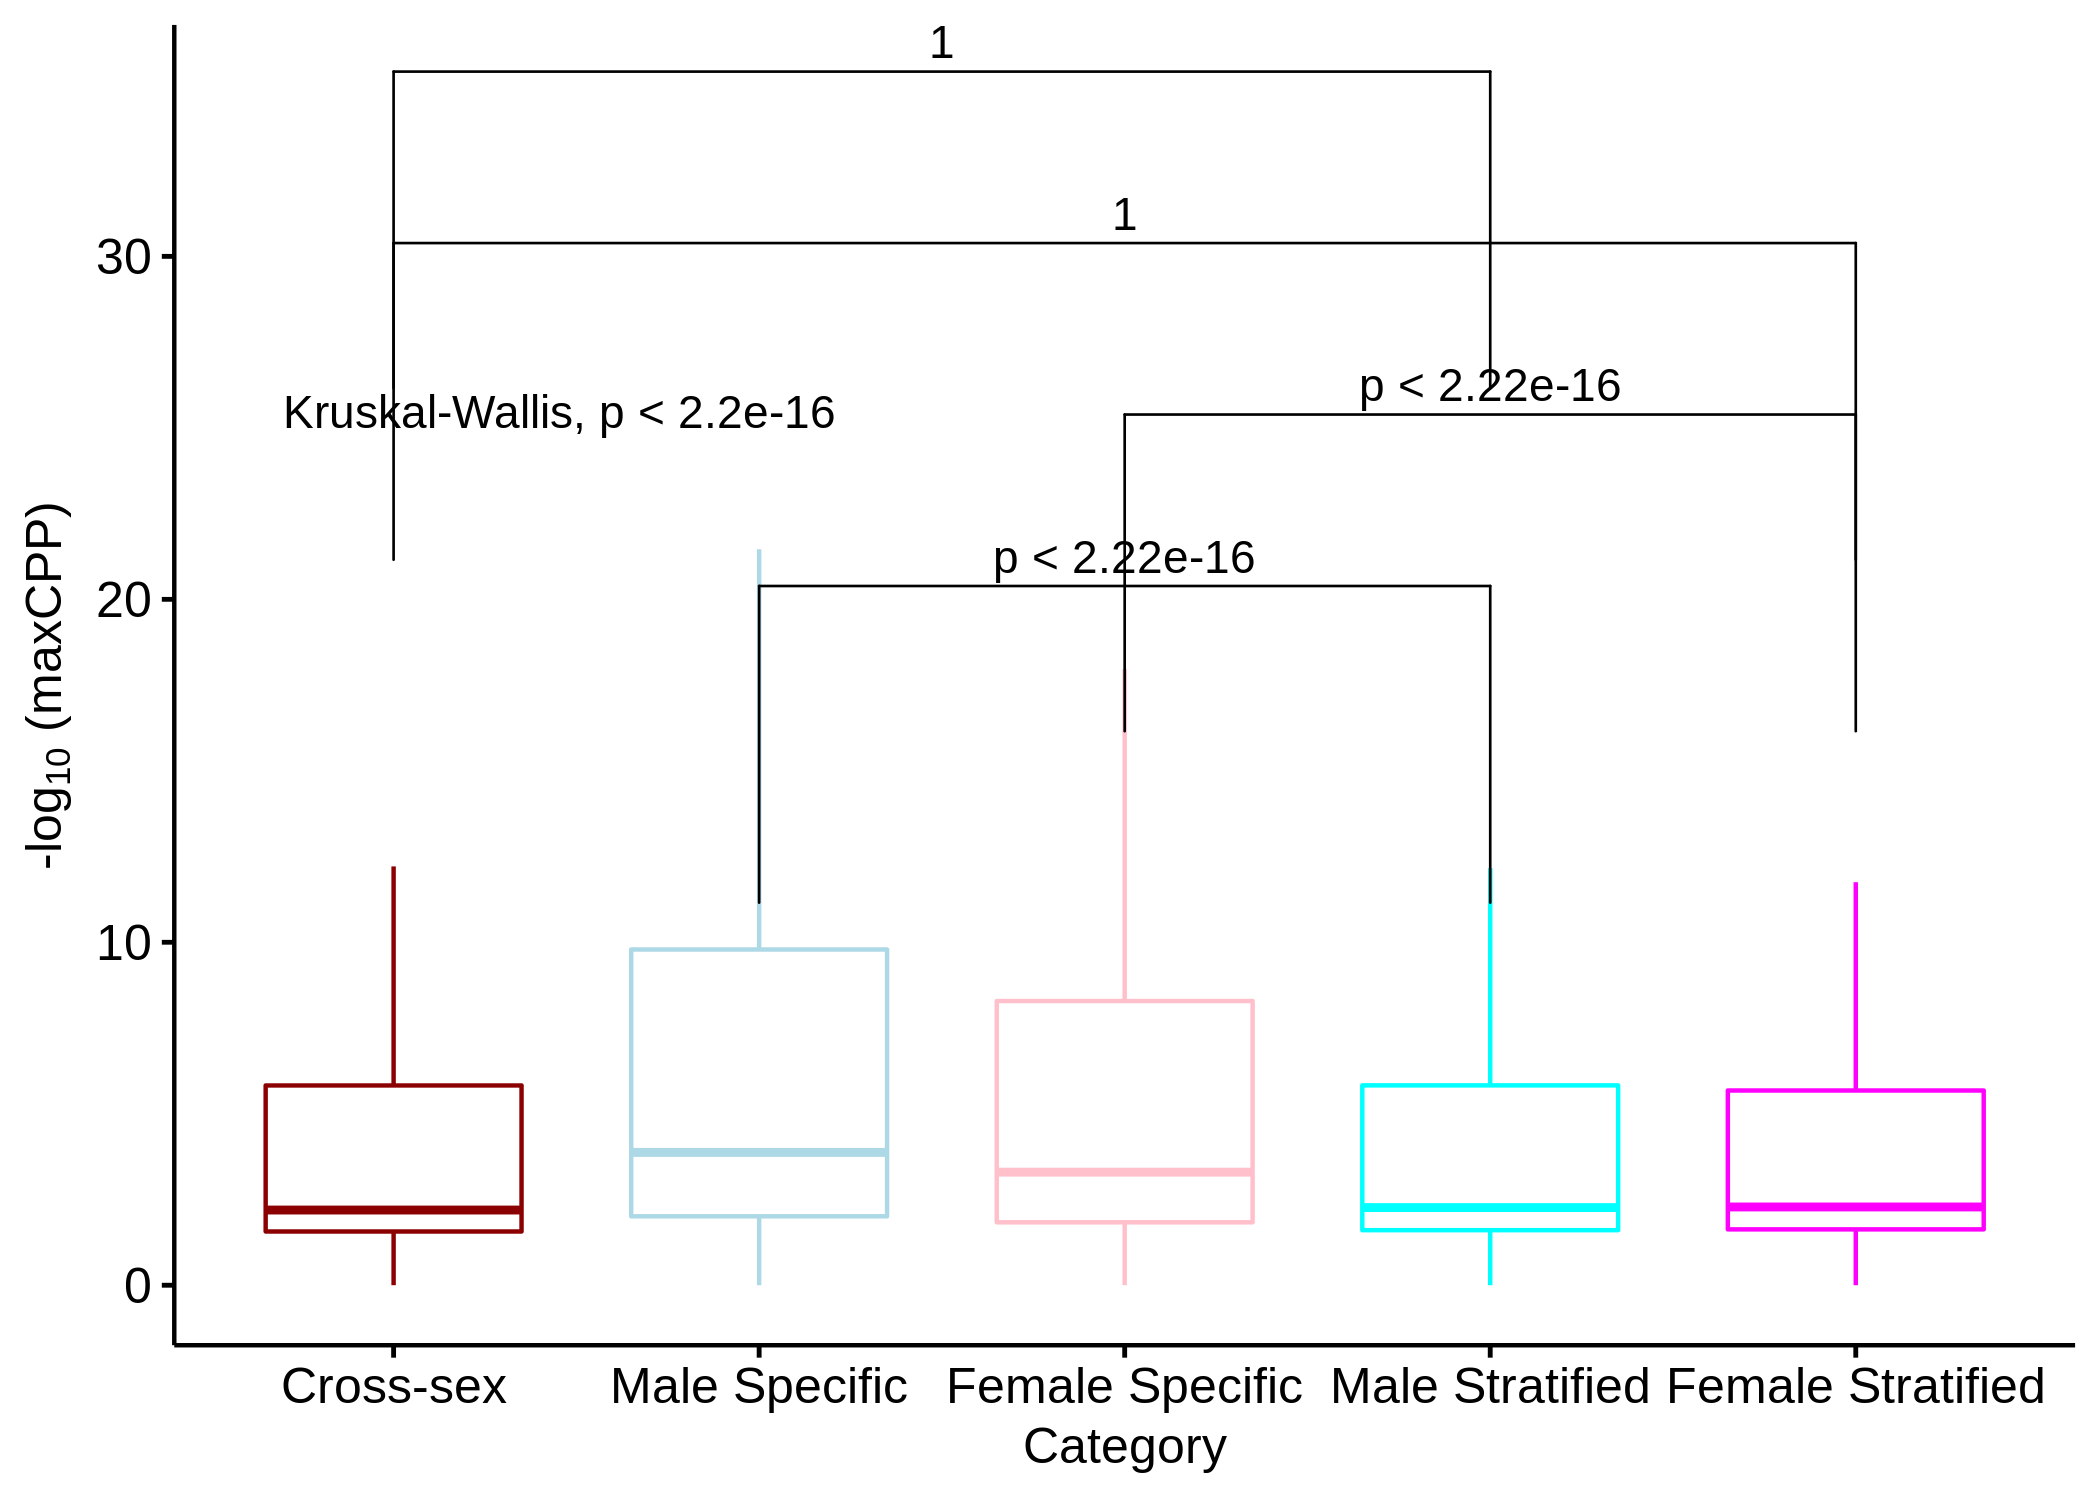

In [5]:
my_comparisons <- list(
    c("Cross-sex", "Male Stratified"),
    c("Cross-sex", "Female Stratified"),
    c("Male Specific", "Male Stratified"),
    c("Female Specific","Female Stratified")
)
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)


to_plot <- na.omit(all_annot_maxCPP[,.(Category,maxCPP=-log10(maxCPP))])
ggboxplot(to_plot,x="Category",y="maxCPP",outlier.shape=NA,color="Category") +
    stat_compare_means(method = "kruskal.test",label.y = 25)+
    stat_compare_means(method = "wilcox.test",comparisons = my_comparisons,label.y = c(20,15,5,10),method.args = list(alternative="greater"))+
    labs(y=bquote("-log"[10]~"(maxCPP)"))+
    scale_color_manual(values=c("dark red","light blue", "pink", "cyan", "magenta"))+
    coord_cartesian(ylim = c(0,35))+
    theme(legend.position = "none")

In [6]:
to_plot <- na.omit(all_annot_maxCPP[,.(Category,maxCPP=-log10(maxCPP))])
res_great<- pairwise.wilcox.test(to_plot$maxCPP,to_plot$Category,p.adjust.method = "BH",alternative="greater")
res_less<- pairwise.wilcox.test(to_plot$maxCPP,to_plot$Category,p.adjust.method = "BH",alternative="less")

In [7]:
res_great$p.value
res_less$p.value

,Cross-sex,Female Specific,Female Stratified,Male Specific
Female Specific,0,NA,NA,NA
Female Stratified,0,1,NA,NA
Male Specific,0,0,0,NA
Male Stratified,0,1,1,1


,Cross-sex,Female Specific,Female Stratified,Male Specific
Female Specific,1,NA,NA,NA
Female Stratified,1,0,NA,NA
Male Specific,1,1,1.000000e+00,NA
Male Stratified,1,0,2.332746e-16,0


## Are quantiles for each CpG site generally "spread-out" in any given annotation?

In [8]:
all_annot_CPP <- rbindlist(
    list(
        cross_caviar[cross_cpg,.(probe,SNP,CPP,Category= "Cross-sex"),on=.(probe)],
        male_caviar[male_specific_cpg,.(probe,SNP,CPP,Category= "Male Specific"),on=.(probe)],
        female_caviar[female_specific_cpg,.(probe,SNP,CPP,Category= "Female Specific"),on=.(probe)],
        male_caviar[male_stratified_cpg,.(probe,SNP,CPP,Category= "Male Stratified"),on=.(probe)],
        female_caviar[female_stratified_cpg,.(probe,SNP,CPP,Category= "Female Stratified"),on=.(probe)]
    )
)

In [9]:
cpg_quant <- na.omit(all_annot_CPP)[,.(
        Min=quantile(CPP,0),
        First=quantile(CPP,0.25),
        Median=quantile(CPP,0.50),
        Last=quantile(CPP,0.75),
        Max=quantile(CPP,1),
        nSNP= .N
    ),by=.(probe,Category)]

In [10]:
fwrite(cpg_quant, "../data/quantiles_cpp_by_cpg.txt")

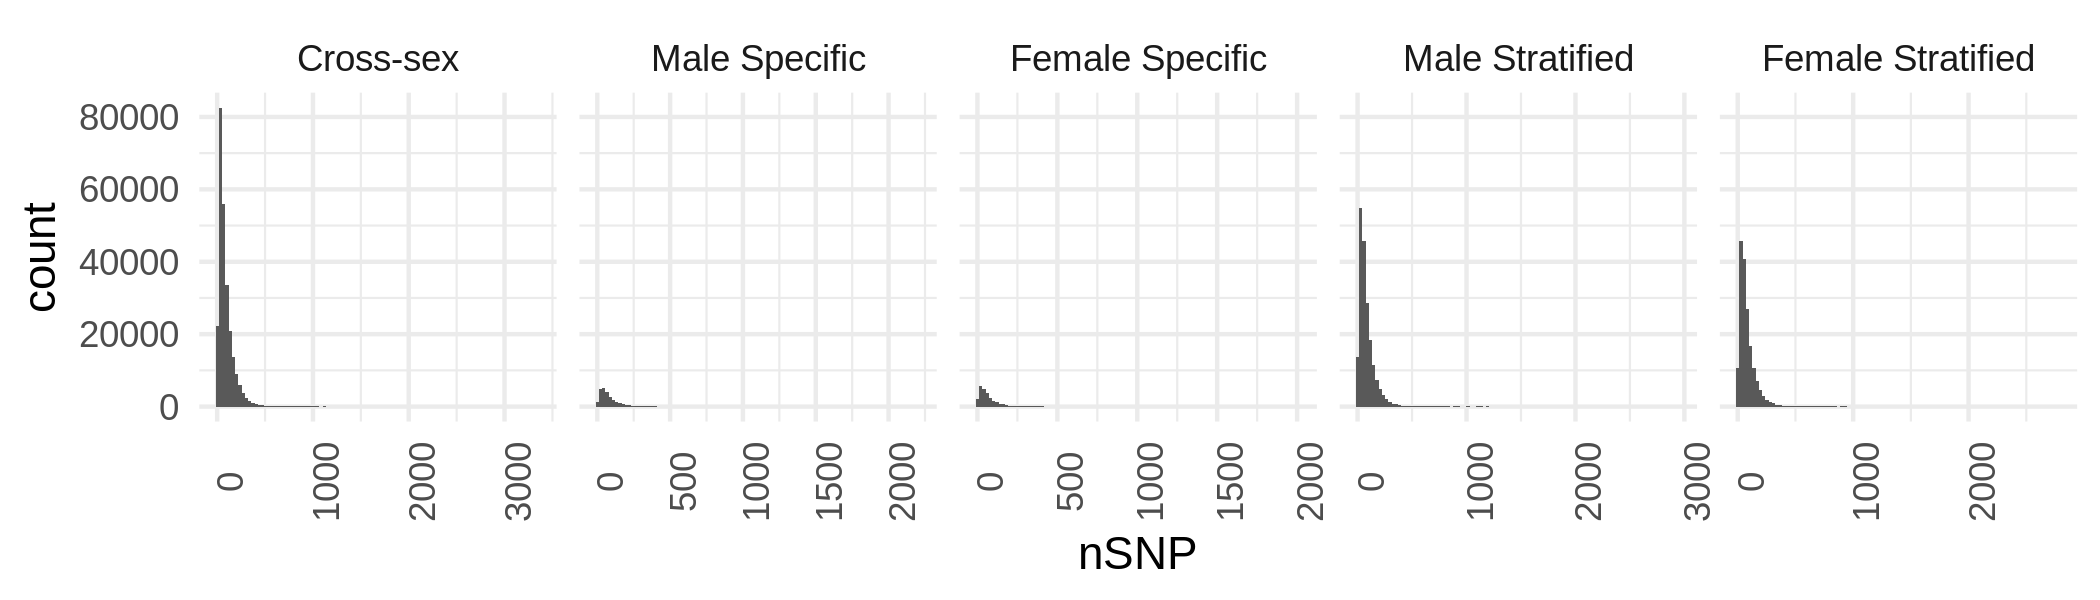

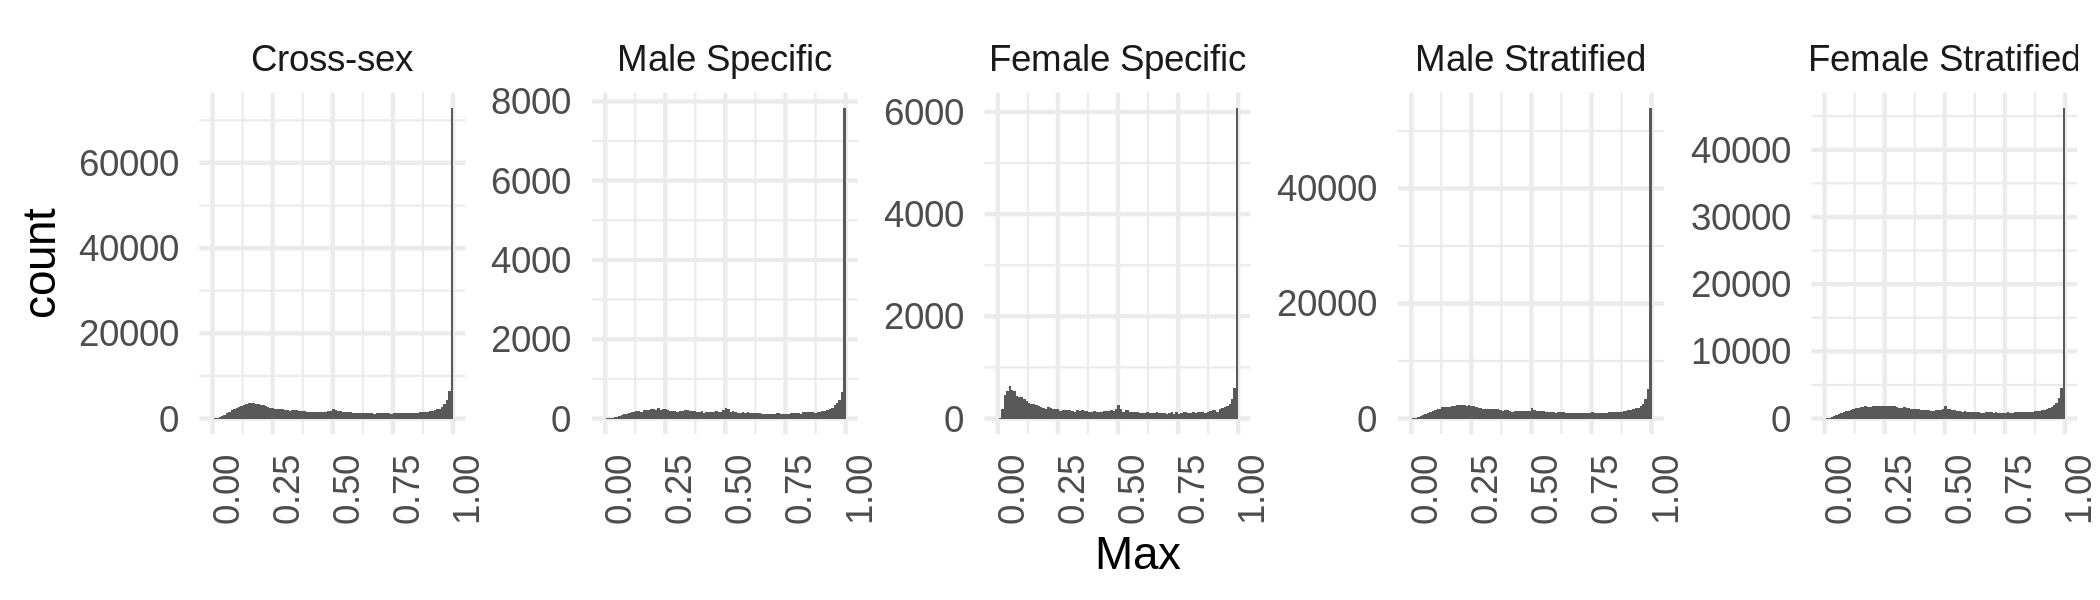

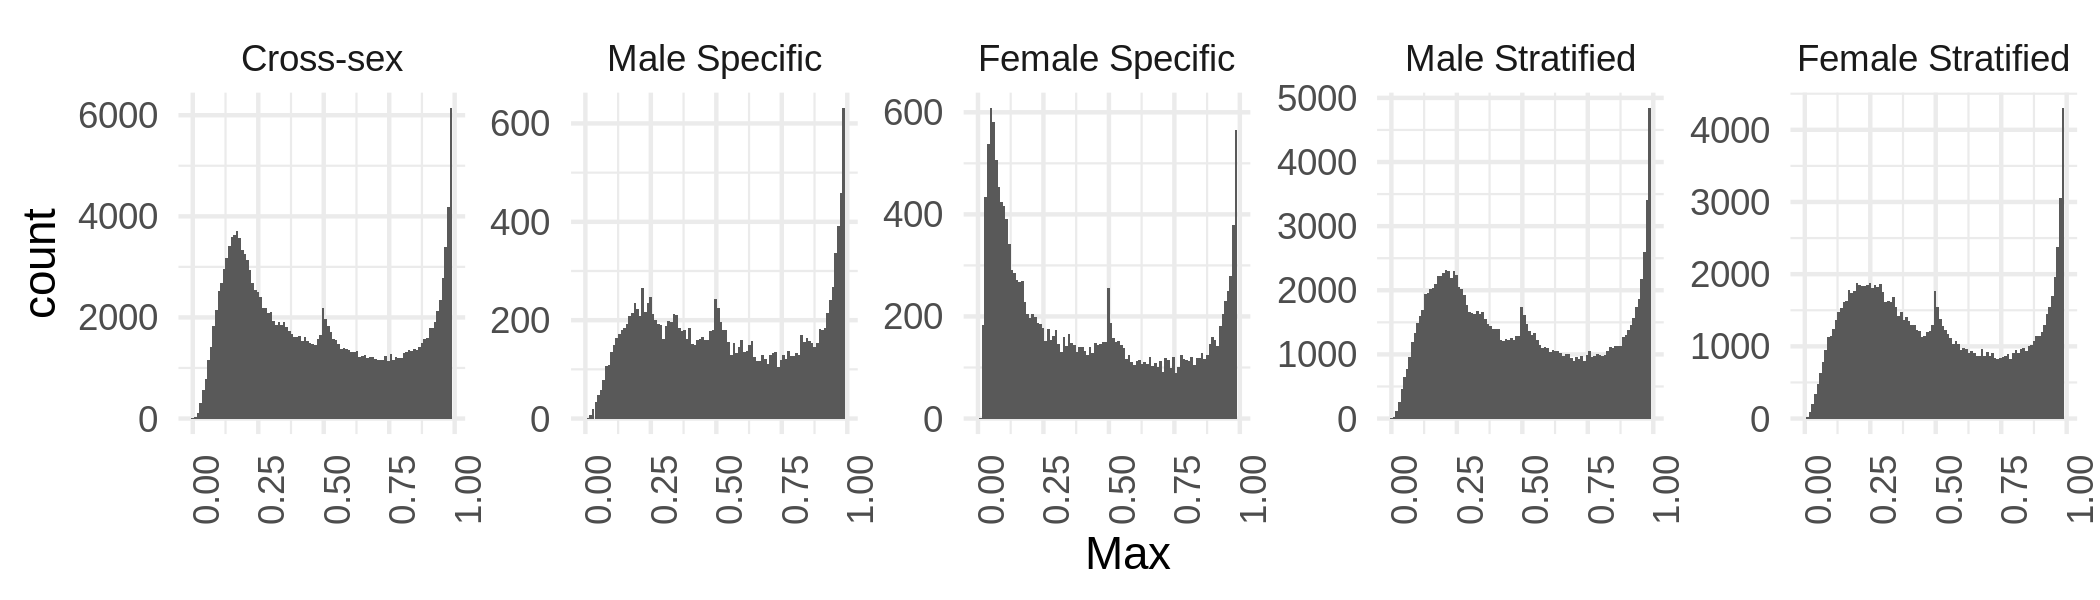

In [11]:
options(width= 15, repr.plot.height= 2, repr.plot.res = 300)
cpg_quant$Category <- factor(cpg_quant$Category,levels=c("Cross-sex","Male Specific","Female Specific", "Male Stratified","Female Stratified"))
ggplot(cpg_quant,aes(nSNP)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_x") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))

ggplot(cpg_quant,aes(Max)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_y") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))

ggplot(cpg_quant[Max <= 0.99],aes(Max)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_y") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))

Warning message in melt.data.table(na.omit(all_annot_maxCPP)[, .(maxCPP = sum(maxCPP), :
“'measure.vars' [maxCPP, Cred95] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”


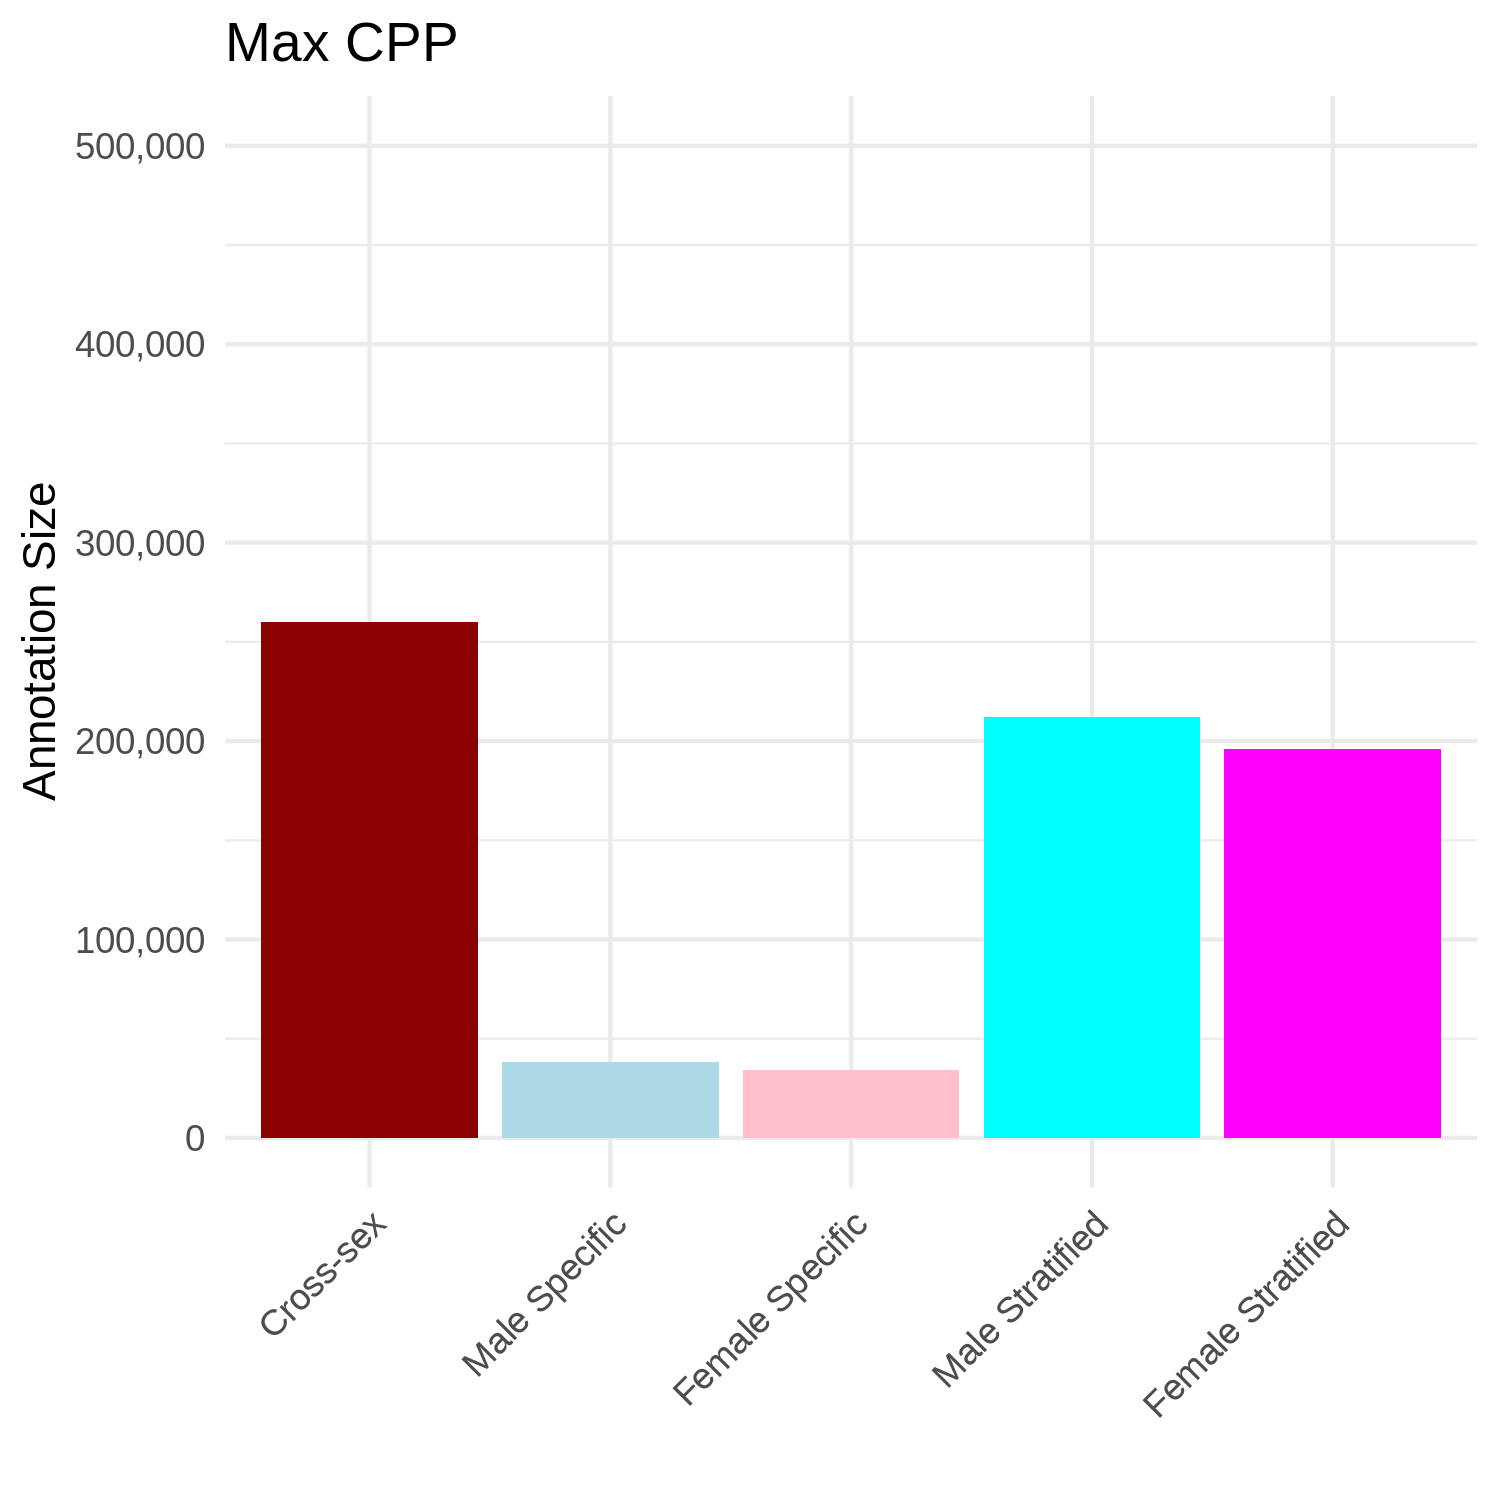

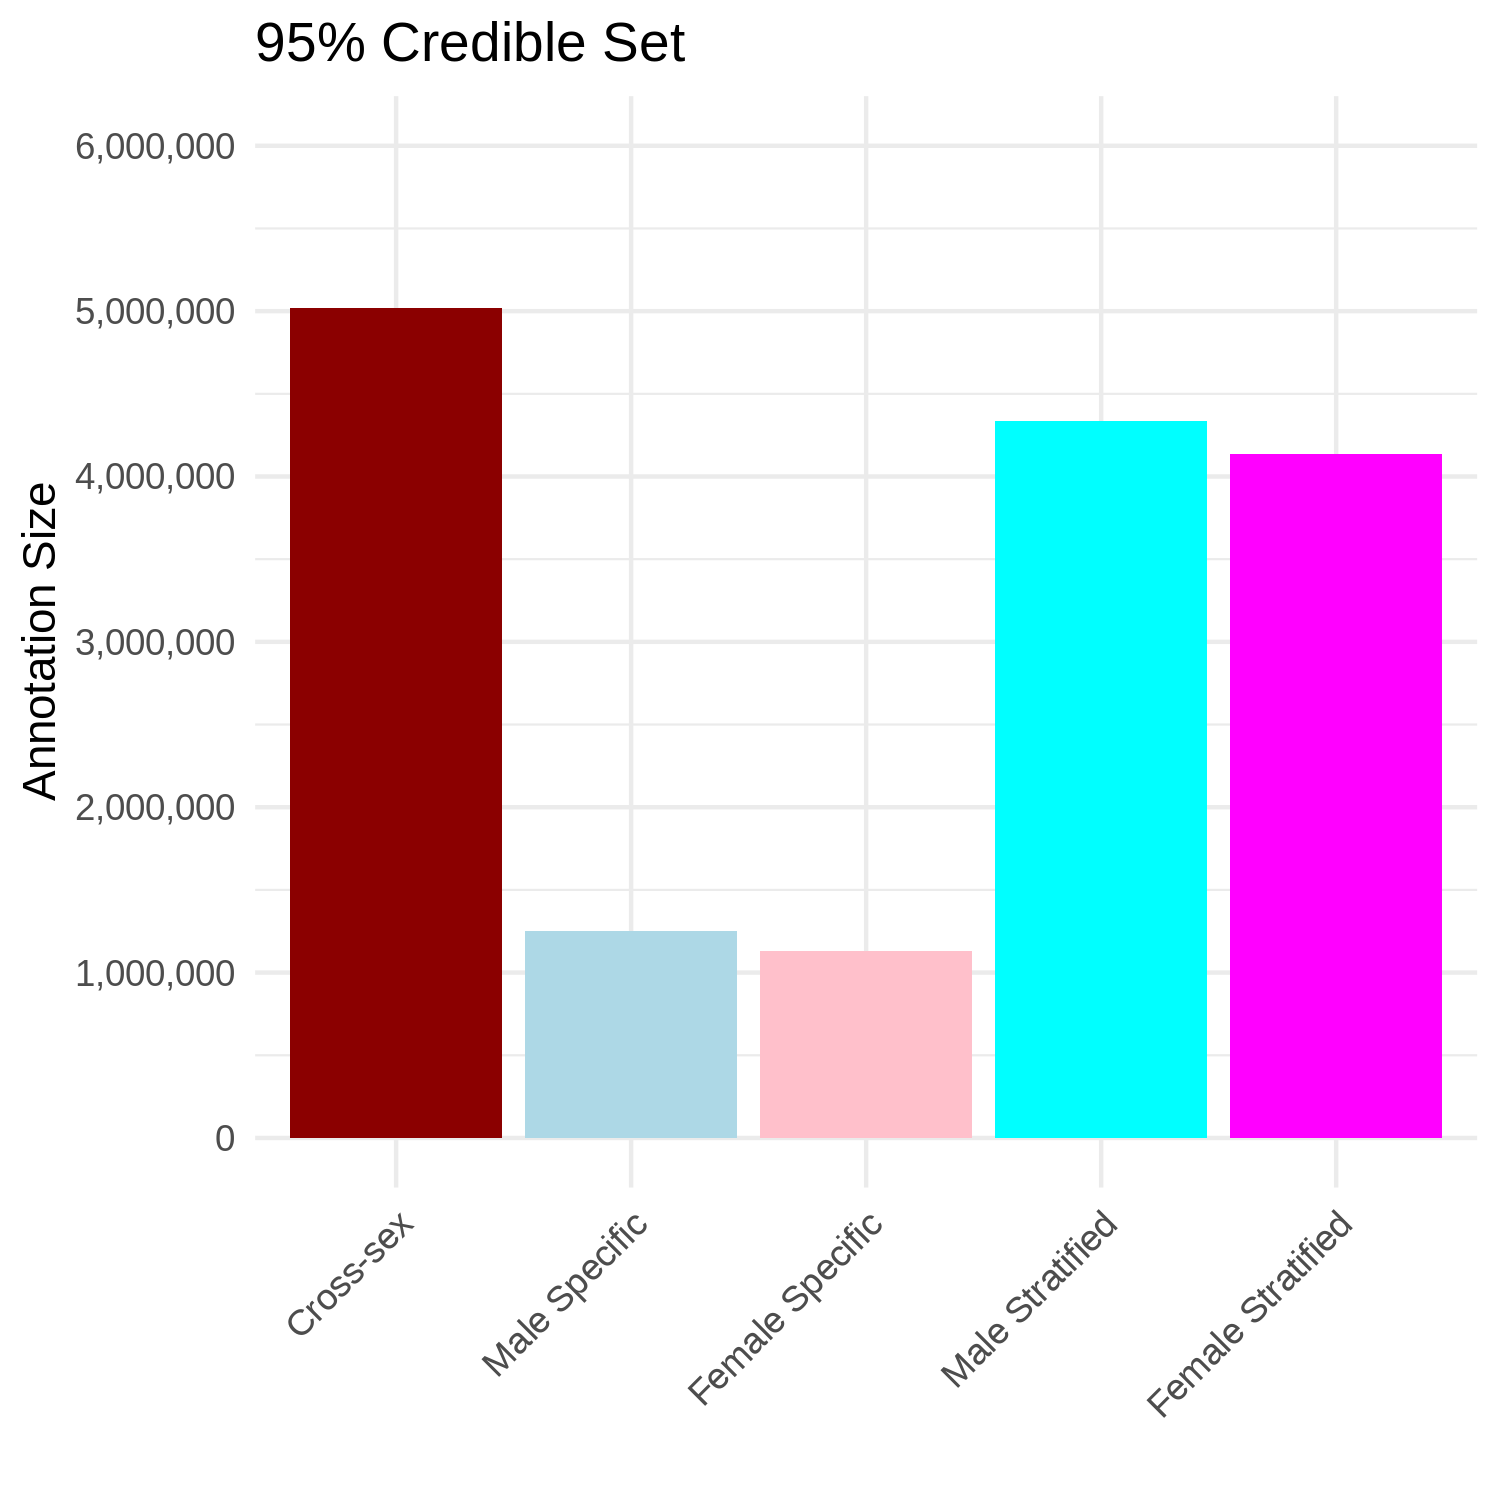

In [12]:
options(repr.plot.width = 5, repr.plot.height= 5, repr.plot.res = 300)

to_plot <- melt(na.omit(all_annot_maxCPP)[,.(maxCPP=sum(maxCPP),Cred95=sum(maxCPP!= 0)),by=.(Category)],
    variable.factor = c("maxCPP","Cred95"),
    id.vars = "Category",
    value.name = "Total"
)
to_plot$Category <- factor(to_plot$Category,levels=c("Cross-sex","Male Specific","Female Specific", "Male Stratified","Female Stratified"))
ggplot(to_plot[variable == "maxCPP"],aes(Category,Total,fill=Category)) + 
    geom_col()+    
    scale_fill_manual(values=c("dark red","light blue", "pink", "cyan", "magenta"))+
    labs(y="Annotation Size",x="",title = "Max CPP")+
    coord_cartesian(ylim = c(0,500000))+
    scale_y_continuous(breaks=seq(0,500000,100000),labels=scales::comma)+
    theme_minimal()+
    theme(legend.position = "none",axis.text.x = element_text(angle=45,hjust=1,vjust=1))

ggplot(to_plot[variable == "Cred95"],aes(Category,Total,fill=Category)) + 
    geom_col()+    
    scale_fill_manual(values=c("dark red","light blue", "pink", "cyan", "magenta"))+
    labs(y="Annotation Size",x="",title = "95% Credible Set")+
    coord_cartesian(ylim = c(0,6e6))+
    scale_y_continuous(breaks=seq(0,6e6,1e6),labels=scales::comma)+
    theme_minimal()+
    theme(legend.position = "none",axis.text.x = element_text(angle=45,hjust=1,vjust=1))

In [13]:
to_plot

Category,variable,Total
<fct>,<fct>,<dbl>
Cross-sex,maxCPP,260134.59
Male Specific,maxCPP,38433.22
Female Specific,maxCPP,34324.30
Male Stratified,maxCPP,212068.91
Female Stratified,maxCPP,196131.91
Cross-sex,Cred95,5016474.00
Male Specific,Cred95,1252709.00
Female Specific,Cred95,1130738.00
Male Stratified,Cred95,4333185.00
